In [3]:
import ROOT
import math
import uproot
import numpy as np
import mplhep as hep
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
BASEDIR_2017 = '/depot/cms/top/jthiema/AnalysisFramework/TopSpinCorr_FullRunIIUL_January2023/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/UnfoldingHistos_Lumiweighted_2017'
BASEDIR_2018 = '/depot/cms/top/jthiema/AnalysisFramework/TopSpinCorr_FullRunIIUL_January2023/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/UnfoldingHistos_Lumiweighted_2018'

In [161]:
JES_UP_17_fileptr   = ROOT.TFile.Open(BASEDIR_2017 + '/JER_UP/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2017UL.root', 'READ')
JES_UP_18_fileptr   = ROOT.TFile.Open(BASEDIR_2018 + '/JER_UP/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2018UL.root', 'READ')

Nominal_17_fileptr  = ROOT.TFile.Open(BASEDIR_2017 + '/Nominal/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2017UL.root', 'READ')
Nominal_18_fileptr  = ROOT.TFile.Open(BASEDIR_2018 + '/Nominal/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2018UL.root', 'READ')

JES_DOWN_17_fileptr = ROOT.TFile.Open(BASEDIR_2017 + '/JER_DOWN/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2017UL.root', 'READ')
JES_DOWN_18_fileptr = ROOT.TFile.Open(BASEDIR_2018 + '/JER_DOWN/emu/histosTUnfold_emu_ttbarsignalplustau_fromDilepton_2018UL.root', 'READ')

In [162]:
gen_b1k_17 = Nominal_17_fileptr.Get('hgen_b1k')
gen_b1k_18 = Nominal_18_fileptr.Get('hgen_b1k')

reco_b1k_17 = Nominal_17_fileptr.Get('hreco_b1k')
reco_b1k_18 = Nominal_18_fileptr.Get('hreco_b1k')

M_JES_UP_b1k_17 = JES_UP_17_fileptr.Get('hrecoVsgen_b1k')
M_JES_UP_b1k_18 = JES_UP_18_fileptr.Get('hrecoVsgen_b1k')

M_Nominal_b1k_17 = Nominal_17_fileptr.Get('hrecoVsgen_b1k')
M_Nominal_b1k_18 = Nominal_18_fileptr.Get('hrecoVsgen_b1k')

M_JES_DOWN_b1k_17 = JES_DOWN_17_fileptr.Get('hrecoVsgen_b1k')
M_JES_DOWN_b1k_18 = JES_DOWN_18_fileptr.Get('hrecoVsgen_b1k')

### This is where we diverge, either add response matrices or treat them as correlated

In [163]:
minval = -1 
maxval =  1

finebins   = 48
coarsebins = 24

In [164]:
%jsroot

In [165]:
c = ROOT.TCanvas('c', 'c', 800,800)
M_Nominal_b1k_17.Draw('colz')
c.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


In [166]:
M_Nominal_b1k_17.ProjectionY().Draw("e")
reco_b1k_17.Draw("e same")
c.Draw()

In [167]:
# Naive addition
reco_added = reco_b1k_17.Clone()
reco_added.Add(reco_b1k_18)

gen_added = gen_b1k_17.Clone()
gen_added.Add(gen_b1k_18)

JES_UP_added = M_JES_UP_b1k_17.Clone()
JES_UP_added.Add(M_JES_UP_b1k_18)

Nominal_added = M_Nominal_b1k_17.Clone()
Nominal_added.Add(M_Nominal_b1k_18)

JES_DOWN_added = M_JES_DOWN_b1k_17.Clone()
JES_DOWN_added.Add(M_JES_DOWN_b1k_18)

True

In [168]:
orientation  = ROOT.TUnfold.kHistMapOutputHoriz
regMode      = ROOT.TUnfold.kRegModeCurvature
con          = ROOT.TUnfold.kEConstraintArea
mode         = ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

# u = ROOT.MyTUnfoldDensity(M,orientation,regMode,con)
unfolding_obj = ROOT.TUnfoldDensity(Nominal_added, orientation, regMode, con)
unfolding_obj.SetInput(reco_added)

unfolding_obj.AddSysError(JES_UP_added  , "Up", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)
unfolding_obj.AddSysError(JES_DOWN_added, "Dn", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)

# Regularize
nScan  = 100
tauMin = 0.001
tauMax = 1.0
iBest  = 0

ScanResult = ROOT.MakeNullPointer(ROOT.TSpline)
logTauX    = ROOT.MakeNullPointer(ROOT.TSpline)
logTauY    = ROOT.MakeNullPointer(ROOT.TSpline)
lCurve     = ROOT.MakeNullPointer(ROOT.TGraph)

# unfolding_obj.ScanLcurve(nScan,tauMin, tauMax, lCurve, logTauX, logTauY)
unfolding_obj.DoUnfold(-1.2)

# nScan  = 30
# tauMin = 0.000001
# tauMax = 1.0

# mode           = ROOT.TUnfoldDensity.kEScanTauRhoAvg
# distribution   = ""
# projectionMode = ""
# axisSteering   =  "*[UOB]"

# unfolding_obj.ScanTau(nScan, tauMin, tauMax, ScanResult, mode, distribution, projectionMode, lCurve, logTauX, logTauY)

# Get output... DOES NOT CONTAIN SYSTEMATICS. 
unfolding_op = unfolding_obj.GetOutput("unfolding_op")

# Get systematic shifts of output
unfolding_op_up = unfolding_obj.GetDeltaSysSource("Up", "o_upshift", "+1#sigma")
unfolding_op_dn = unfolding_obj.GetDeltaSysSource("Dn", "o_dnshift", "-1#sigma")
unfolding_op_up.SetLineStyle(2)
unfolding_op_dn.SetLineStyle(2)

# Get various covariances
cov_tot       = unfolding_obj.GetEmatrixTotal("cov", "Covariance Matrix")
# cov_sys     = unfolding_obj.GetEmatrixSysUncorr("cov_sys" , "Covariance Matrix from Uncorrelated Uncertainties")
#cov_sys      = unfolding_obj.GetEmatrixSysSource("cov_sys" , "Covariance Matrix from Systematic Uncertainties")
cov_stat_data = unfolding_obj.GetEmatrixInput("cov_stat_data", "Covariance Matrix from Stat Uncertainties of Input Data")

# Now prepare various distributions. 
unfolding_unc_stat = unfolding_op.Clone("unfolding_unc_stat") # Unfolding and stat unc
unfolding_unc_sys  = unfolding_op.Clone("unfolding_unc_sys")  # Syst uncertainty
unfolding_unc_tot  = unfolding_op.Clone("unfolding_unc_tot")  # Total uncertainty

unfolding_unc_sys.SetLineStyle(2)

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output

for i in range( 0, unfolding_op.GetNbinsX() + 1):
    
    unc_tot = ROOT.TMath.Sqrt( cov_tot.GetBinContent(i,i) )
    
    unfolding_unc_tot.SetBinContent(i, unc_tot)    
    unfolding_op.SetBinError(i, unc_tot)
    
    yup = abs(unfolding_op_up.GetBinContent(i))
    ydn = abs(unfolding_op_dn.GetBinContent(i))
    
    delta_y = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
    
    unfolding_unc_sys.SetBinContent(i, delta_y)
    unfolding_unc_stat.SetBinContent(i, math.sqrt(cov_stat_data.GetBinContent(i,i) ))

gen_added_2 = gen_added.Clone("gen_added_2")
gen_added_2.Rebin(finebins//coarsebins)

unfolding_op.SetMarkerStyle(20)
unfolding_op.SetMarkerColor(1)

unfolding_unc_stat.SetMarkerStyle(0)
unfolding_unc_stat.SetLineColor(2)

gen_added_2.SetMarkerStyle(21)
gen_added_2.SetMarkerColor(4)
gen_added_2.SetMarkerStyle(4)
gen_added_2.SetLineColor(4)

c = ROOT.TCanvas("c","c")
unfolding_op.SetMinimum(0.0)
unfolding_op.Draw()
unfolding_unc_stat.Draw("e same")
gen_added_2.Draw("e same")

leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry(unfolding_op      , "Unfolded, total unc",'p')
leg2.AddEntry(unfolding_unc_stat, "Stat+unfolding unc",'l')
leg2.AddEntry(gen_added_2, "Gen/True",'p')
leg2.Draw()
c.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c
Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 48 input bins and 24 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:ttbargen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #25 (xaxis:ttbargen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=3 axisSteering=*[UOB]


In [169]:
print (lCurve)
if lCurve:
    cl = ROOT.TCanvas("cl", "cl", 500, 500)
    lCurve.Draw("alp")
    cl.Draw()

<cppyy.gbl.TGraph object at 0x(nil)>


In [170]:
c2       = ROOT.TCanvas("c2", "c2", 500, 500)
closure  = gen_added_2.Clone("closure")
closure2 = gen_added_2.Clone("closure2")

closure.SetMarkerColor(1)
closure.SetLineColor(1)

closure2.SetMarkerColor(2)
closure2.SetLineColor(2)

closure.SetTitle("true / unfolded")

closure.Divide(unfolding_op)
closure2.Divide(unfolding_unc_stat)

closure.Draw('e1')
closure2.Draw('e1 same')
# closure.SetMaximum(1.1)

legclosure = ROOT.TLegend(0.4, 0.7, 0.86, 0.86)
legclosure.SetBorderSize(0)
legclosure.SetFillColor(0)
legclosure.AddEntry(closure, "True / Unfolded, All Unc.", 'p')
legclosure.AddEntry(closure2, "True / Unfolded, Stat. Unc.", 'p')
legclosure.Draw()
c2.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c2
Error in <TH1D::Divide>: Cannot divide histograms with different number of bins
Error in <TH1D::Divide>: Cannot divide histograms with different number of bins


In [171]:
ccov = ROOT.TCanvas("ccov", "Covariance Matrix from Stat Uncertainties on data", 400, 400)
cov_stat_data.Draw('colz')
#ccov.SetLogz()
ccov.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: ccov


### Treatment for correlated matrices

In [172]:
import mplhep as hep
hep.style.use(hep.style.ATLAS)
import matplotlib as mpl

In [173]:
# Number of finebins = 48, coarsebins = 24, add 2 for over and underflow
M_JES_UP_2017   = np.zeros((26,50))
M_Nominal_2017  = np.zeros((26,50))
M_JES_DOWN_2017 = np.zeros((26,50))

M_JES_UP_2018   = np.zeros((26,50))
M_Nominal_2018  = np.zeros((26,50))
M_JES_DOWN_2018 = np.zeros((26,50))

for i in range(0, M_Nominal_b1k_17.GetNbinsX()+2):    
    for j in range(0, M_Nominal_b1k_17.GetNbinsY()+2):   
        
        M_JES_UP_2017[i][j]   = M_JES_UP_b1k_17.GetBinContent(i,j)
        M_Nominal_2017[i][j]  = M_Nominal_b1k_17.GetBinContent(i,j)
        M_JES_DOWN_2017[i][j] = M_JES_DOWN_b1k_17.GetBinContent(i,j)
        
for i in range(0, M_Nominal_b1k_18.GetNbinsX()+2):    
    for j in range(0, M_Nominal_b1k_18.GetNbinsY()+2):  
        
        M_JES_UP_2018[i][j]   = M_JES_UP_b1k_18.GetBinContent(i,j)
        M_Nominal_2018[i][j]  = M_Nominal_b1k_18.GetBinContent(i,j)
        M_JES_DOWN_2018[i][j] = M_JES_DOWN_b1k_18.GetBinContent(i,j)

$$\text{Consider 3 systematic sources}$$
$\text{Uncorrelated part}$ :

$$ Source 1 \rightarrow \sqrt{1 - \rho_{17,18}} \: (M_{17}^{JES \_UP} - M_{17}^{Nom}) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$
$$ Source 2 \rightarrow  \sqrt{1 - \rho_{17,18}} \: (M_{18}^{JES \_UP} - M_{18}^{Nom}) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$

$\text{Correlated part}$ :

$$ Source 3 \rightarrow \sqrt{\rho_{17,18}} \: ((M_{17}^{JES \_UP} - M_{17}^{Nom}) + (M_{18}^{JES \_UP} - M_{18}^{Nom})) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$

$$ $$
$$\text{Similarily for down}$$

$\text{Uncorrelated part}$ :
$$ Source 1 \rightarrow \sqrt{1 - \rho_{17,18}} \: (M_{17}^{Nom} - M_{17}^{JES \_DOWN}) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$
$$ Source 2 \rightarrow  \sqrt{1 - \rho_{17,18}} \: (M_{18}^{Nom} - M_{18}^{JES \_DOWN}) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$

$\text{Correlated part}$ :

$$ Source 3 \rightarrow \sqrt{\rho_{17,18}} \: ((M_{17}^{Nom} - M_{17}^{JES \_DOWN}) + (M_{18}^{Nom} - M_{18}^{JES \_DOWN})) \, + (M_{17}^{Nom} + M_{18}^{Nom}) $$

$ \text{Add the uncertainty from all sources in quadrature} $

In [242]:
import math
del_17_18 = 0.99

del_17_17 = (1 - del_17_18)
del_18_18 = (1 - del_17_18)

M_JES_UP_17     = math.sqrt(del_17_17) * (M_JES_UP_2017  - M_Nominal_2017) + (M_Nominal_2017 + M_Nominal_2018)
M_JES_UP_18     = math.sqrt(del_18_18) * (M_JES_UP_2018  - M_Nominal_2018) + (M_Nominal_2017 + M_Nominal_2018)
M_JES_UP_17_18  = math.sqrt(del_17_18) * ((M_JES_UP_2018 - M_Nominal_2018) + (M_JES_UP_2017  - M_Nominal_2017)) + (M_Nominal_2017 + M_Nominal_2018)

M_JES_DOWN_17    = math.sqrt(del_17_17) * (M_Nominal_2017 - M_JES_DOWN_2017)  + (M_Nominal_2017 + M_Nominal_2018)
M_JES_DOWN_18    = math.sqrt(del_18_18) * (M_Nominal_2018 - M_JES_DOWN_2018)  + (M_Nominal_2017 + M_Nominal_2018)
M_JES_DOWN_17_18 = math.sqrt(del_17_18) * ((M_Nominal_2018  - M_JES_DOWN_2018) +  (M_Nominal_2017 - M_JES_DOWN_2017)) + (M_Nominal_2017 + M_Nominal_2018)

In [243]:
JES_UP_corr_17    = JES_UP_added.Clone()
JES_UP_corr_18    = JES_UP_added.Clone()
JES_UP_corr_17_18 = JES_UP_added.Clone()

JES_DOWN_corr_17    = JES_DOWN_added.Clone()
JES_DOWN_corr_18    = JES_DOWN_added.Clone()
JES_DOWN_corr_17_18 = JES_DOWN_added.Clone()

for i in range(0, M_Nominal_b1k_17.GetNbinsX() + 2):    
    for j in range(0, M_Nominal_b1k_17.GetNbinsY() + 2):
        JES_UP_corr_17.SetBinContent(i,j, M_JES_UP_17[i][j])
        JES_UP_corr_18.SetBinContent(i,j, M_JES_UP_18[i][j])
        JES_UP_corr_17_18.SetBinContent(i,j, M_JES_UP_17_18[i][j])
        
        JES_DOWN_corr_17.SetBinContent(i,j,M_JES_DOWN_17[i][j])
        JES_DOWN_corr_18.SetBinContent(i,j,M_JES_DOWN_18[i][j])
        JES_DOWN_corr_17_18.SetBinContent(i,j,M_JES_DOWN_17_18[i][j])

In [244]:
orientation  = ROOT.TUnfold.kHistMapOutputHoriz
regMode      = ROOT.TUnfold.kRegModeCurvature
con          = ROOT.TUnfold.kEConstraintArea 
mode         = ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

unfolding_obj_corr = ROOT.TUnfoldDensity(Nominal_added, orientation, regMode, con)

# Question : should this also be treated differently ?
unfolding_obj_corr.SetInput(reco_added)

unfolding_obj_corr.AddSysError(JES_UP_corr_17   , "Up_17"   , orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)
unfolding_obj_corr.AddSysError(JES_UP_corr_18   , "Up_18"   , orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)
unfolding_obj_corr.AddSysError(JES_UP_corr_17_18, "Up_17_18", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)

unfolding_obj_corr.AddSysError(JES_DOWN_corr_17   , "Dn_17"   , orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)
unfolding_obj_corr.AddSysError(JES_DOWN_corr_18   , "Dn_18"   , orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)
unfolding_obj_corr.AddSysError(JES_DOWN_corr_17_18, "Dn_17_18", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)


# Regularize
nScan  = 100
tauMin = 0.001
tauMax = 1.0
iBest  = 0

logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
lCurve  = ROOT.MakeNullPointer(ROOT.TGraph)

# unfolding_obj_corr.ScanLcurve(nScan,tauMin, tauMax, lCurve, logTauX, logTauY)
# unfolding_obj_corr.ScanLcurve(nScan,tauMin, tauMax, lCurve, logTauX, logTauY)
unfolding_obj_corr.DoUnfold(-1.2)

# Get output... DOES NOT CONTAIN SYSTEMATICS. 
unfolding_op_corr = unfolding_obj_corr.GetOutput("unfolding_op_corr")

# Get systematic shifts of output
unfolding_op_up_corr_17    = unfolding_obj_corr.GetDeltaSysSource("Up_17"   , "o_upshift", "+1#sigma")
unfolding_op_up_corr_18    = unfolding_obj_corr.GetDeltaSysSource("Up_18"   , "o_upshift", "+1#sigma")
unfolding_op_up_corr_17_18 = unfolding_obj_corr.GetDeltaSysSource("Up_17_18", "o_upshift", "+1#sigma")


unfolding_op_dn_corr_17    = unfolding_obj_corr.GetDeltaSysSource("Dn_17"   , "o_dnshift", "-1#sigma")
unfolding_op_dn_corr_18    = unfolding_obj_corr.GetDeltaSysSource("Dn_18"   , "o_dnshift", "-1#sigma")
unfolding_op_dn_corr_17_18 = unfolding_obj_corr.GetDeltaSysSource("Dn_17_18", "o_dnshift", "-1#sigma")


unfolding_op_up_corr_17.SetLineStyle(2)
unfolding_op_dn_corr_17.SetLineStyle(2)

# Get various covariances
cov_tot_corr       = unfolding_obj_corr.GetEmatrixTotal("cov_corr", "Covariance Matrix")
# cov_sys          = unfolding_obj_corr.GetEmatrixSysUncorr("cov_uncorr" , "Covariance Matrix from Uncorrelated Uncertainties")
# cov_sys_corr     = unfolding_obj_corr.GetEmatrixSysSource("cov_sys"  , "Covariance Matrix from Systematic Uncertainties")
cov_stat_data_corr = unfolding_obj_corr.GetEmatrixInput("cov_stat_data", "Covariance Matrix from Stat Uncertainties of Input Data")

# Now prepare various distributions. 
unfolding_unc_stat_corr = unfolding_op_corr.Clone("unfolding_unc_stat_corr") # Unfolding and stat unc
unfolding_unc_sys_corr  = unfolding_op_corr.Clone("unfolding_unc_sys_corr")  # Syst uncertainty
unfolding_unc_tot_corr  = unfolding_op_corr.Clone("unfolding_unc_tot_corr")  # Total uncertainty

unfolding_unc_sys_corr.SetLineStyle(2)

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output

for i in range(0, unfolding_op_corr.GetNbinsX() + 1):
    
    unc_tot = ROOT.TMath.Sqrt(cov_tot_corr.GetBinContent(i,i))
    
    unfolding_unc_tot_corr.SetBinContent(i, unc_tot)    
    unfolding_op_corr.SetBinError(i, unc_tot)
    
    yup_corr_17    = abs(unfolding_op_up_corr_17.GetBinContent(i))
    yup_corr_18    = abs(unfolding_op_up_corr_18.GetBinContent(i))
    yup_corr_17_18 = abs(unfolding_op_up_corr_17_18.GetBinContent(i))
    
    ydn_corr_17    = abs(unfolding_op_dn_corr_17.GetBinContent(i))
    ydn_corr_18    = abs(unfolding_op_dn_corr_18.GetBinContent(i))
    ydn_corr_17_18 = abs(unfolding_op_dn_corr_17_18.GetBinContent(i))
    
    delta_y_corr = ROOT.TMath.Sqrt( (yup_corr_17**2 + yup_corr_18**2 + yup_corr_17_18**2 + ydn_corr_17**2 + ydn_corr_18**2 + ydn_corr_17_18**2) )
    
    unfolding_unc_sys_corr.SetBinContent(i , delta_y_corr)
    unfolding_unc_stat_corr.SetBinContent(i, math.sqrt(cov_stat_data_corr.GetBinContent(i,i)))

gen_added_2 = gen_added.Clone("gen_added_2")
gen_added_2.Rebin(finebins//coarsebins)

unfolding_op_corr.SetMarkerStyle(20)
unfolding_op_corr.SetMarkerColor(1)

unfolding_unc_stat_corr.SetMarkerStyle(0)
unfolding_unc_stat_corr.SetLineColor(2)

gen_added_2.SetMarkerStyle(21)
gen_added_2.SetMarkerColor(4)
gen_added_2.SetMarkerStyle(4)
gen_added_2.SetLineColor(4)

c = ROOT.TCanvas("c","c")
unfolding_op_corr.SetMinimum(0.0)
unfolding_op_corr.Draw()
unfolding_unc_stat_corr.Draw("e same")
gen_added_2.Draw("e same")

leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry(unfolding_op_corr      , "Unfolded, total unc",'p')
leg2.AddEntry(unfolding_unc_stat_corr, "Stat+unfolding unc",'l')
leg2.AddEntry(gen_added_2, "Gen/True",'p')
leg2.Draw()
c.Draw()

TFile::Append:0: RuntimeWarning: Replacing existing TH1: unfolding_op_corr (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_upshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_upshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_upshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_dnshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_dnshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: o_dnshift (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: cov_corr (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: cov_stat_data (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c
Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow a

In [245]:
unfolding_op_dn_corr_17.GetBinContent(24)

3.0214239360741995

In [246]:
unfolding_op_dn.GetBinContent(24)

-94.80469038949047

In [247]:
print (lCurve)
if lCurve:
    cl = ROOT.TCanvas("cl", "cl", 500, 500)
    lCurve.Draw("alp")
    cl.Draw()

<cppyy.gbl.TGraph object at 0x(nil)>


In [248]:
ccov = ROOT.TCanvas("ccov", "Covariance Matrix for Stat Uncertainties on data", 400, 400)
cov_stat_data.Draw('colz')
#ccov.SetLogz()
ccov.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: ccov


In [249]:
# ccov = ROOT.TCanvas("ccov", "Covariance Matrix for Stat Uncertainties on data", 400, 400)
# # cov_tot.Draw('colz')
# # cov_tot_corr.Draw('colz')
# # ccov.SetLogz()
# ccov.Draw()

In [250]:
c2       = ROOT.TCanvas("c2", "c2", 500, 500)
closure  = gen_added_2.Clone("closure")
closure2 = gen_added_2.Clone("closure2")

closure.SetMarkerColor(1)
closure.SetLineColor(1)

closure2.SetMarkerColor(2)
closure2.SetLineColor(2)

closure.SetTitle("true / unfolded")

closure.Divide(unfolding_op_corr)
closure2.Divide(unfolding_unc_stat_corr)

closure.Draw('e1')
closure2.Draw('e1 same')
#closure.SetMaximum(1.1)

legclosure = ROOT.TLegend(0.4, 0.7, 0.86, 0.86)
legclosure.SetBorderSize(0)
legclosure.SetFillColor(0)
legclosure.AddEntry(closure, "True / Unfolded, All Unc.", 'p')
legclosure.AddEntry(closure2, "True / Unfolded, Stat. Unc.", 'p')
legclosure.Draw()
c2.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c2
Error in <TH1D::Divide>: Cannot divide histograms with different number of bins
Error in <TH1D::Divide>: Cannot divide histograms with different number of bins


In [251]:
uncorr_sys = []
corr_sys   = []

uncorr_stat = []
corr_stat   = []

for i in range(1, unfolding_op_corr.GetNbinsX() + 1) :
    uncorr_sys.append(unfolding_unc_sys.GetBinContent(i))
    corr_sys.append(unfolding_unc_sys_corr.GetBinContent(i))

    uncorr_stat.append(unfolding_unc_stat.GetBinContent(i))
    corr_stat.append( unfolding_unc_stat_corr.GetBinContent(i))

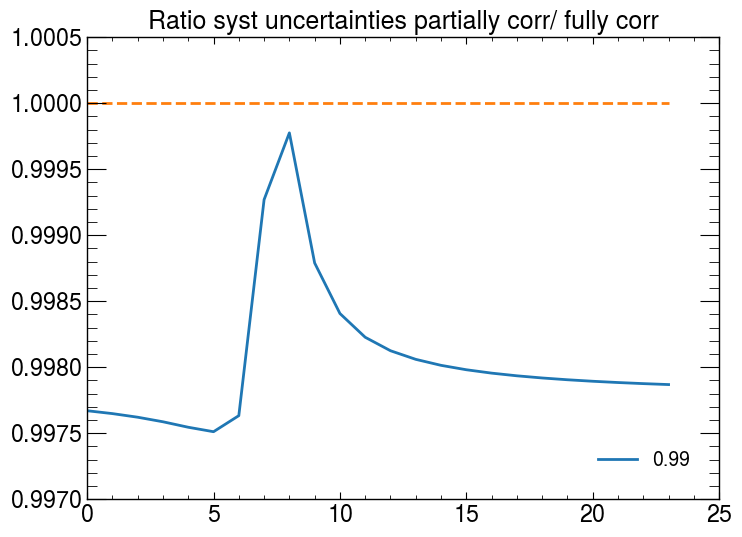

In [252]:
# plt.plot(uncorr_sys)
# plt.plot(corr_sys)
plt.title('Ratio syst uncertainties partially corr/ fully corr', fontsize=18)
plt.plot(np.divide(np.array(corr_sys), np.array(uncorr_sys)), label=del_17_18)
plt.plot(np.ones(len(corr_sys)), '--')
plt.legend()
#plt.ylim(0.9,1.1)

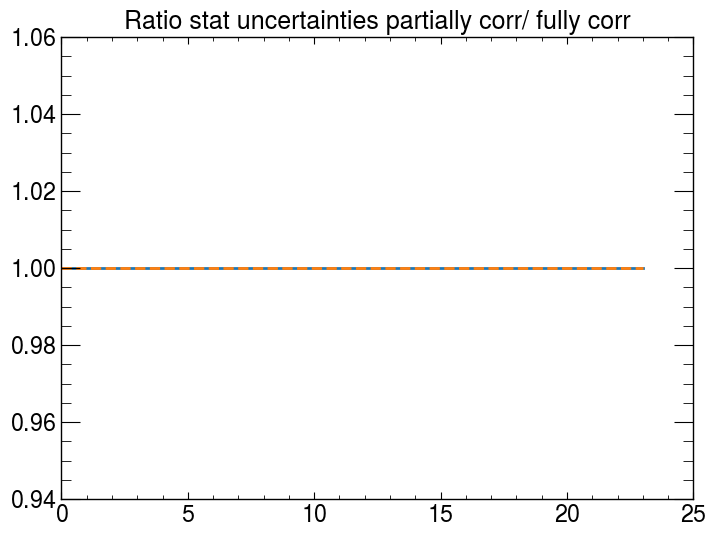

In [253]:
# plt.plot(uncorr_stat)
# plt.plot(corr_stat)
plt.title('Ratio stat uncertainties partially corr/ fully corr' , fontsize=18)
plt.plot(np.divide(np.array(corr_stat), np.array(uncorr_stat)))
plt.plot(np.ones(len(corr_sys)), '--')
# plt.ylim(0.95,1.05)

In [254]:
corr_sys

[58.00159965888106,
 50.11896753002135,
 42.25289302294002,
 34.41076353128152,
 26.617775472394214,
 18.950539785142226,
 11.688254308369524,
 6.445694219343021,
 8.620884748263768,
 15.334038849711195,
 22.889671033901223,
 30.666136246109158,
 38.522522436117725,
 46.409997910968066,
 54.306823783988186,
 62.20197363109565,
 70.0897160062064,
 77.96741402177025,
 85.83445774503265,
 93.69170086170381,
 101.54108207880837,
 109.3853037457504,
 117.22734468431031,
 125.06995598466425]

In [255]:
uncorr_sys

[58.13707121701359,
 50.23712538417563,
 42.3536694826067,
 34.494029405137375,
 26.68329394803608,
 18.99782868667412,
 11.715992439397516,
 6.450410166560367,
 8.622827925605554,
 15.352631066504708,
 22.926209972457116,
 30.7206263058768,
 38.59491573909023,
 46.50025568606691,
 54.414912840504364,
 62.327861794465825,
 70.23337023736099,
 78.1288005061726,
 86.01354303862037,
 93.88845377740124,
 101.75547584533408,
 109.61731791516713,
 117.4769661084053,
 125.3371786489597]

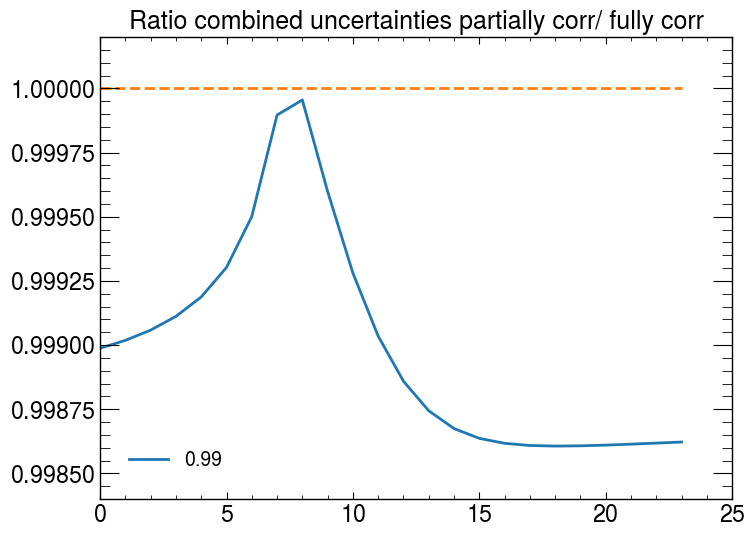

In [256]:
plt.title('Ratio combined uncertainties partially corr/ fully corr', fontsize=18)
plt.plot(np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat)), label=del_17_18)
plt.plot(np.ones(len(corr_sys)), '--')
plt.legend()
# plt.ylim(0.8,1.2)

In [257]:
# rho_0_1  = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))
# rho_0_3  = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))
# rho_0_5  = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))
# rho_0_7  = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))
# rho_0_9  = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))
# rho_0_99 = np.divide(np.array(corr_sys) + np.array(corr_stat), np.array(uncorr_sys) + np.array(uncorr_stat))

(0.8, 1.2)

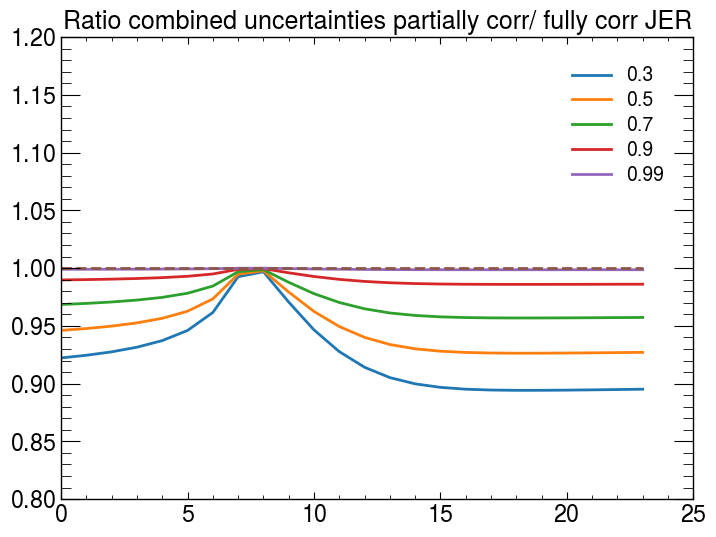

In [258]:
plt.title('Ratio combined uncertainties partially corr/ fully corr JER', fontsize=18)
# plt.plot(rho_0_1 , label="0.1")
plt.plot(rho_0_3 , label="0.3")
plt.plot(rho_0_5 , label="0.5")
plt.plot(rho_0_7 , label="0.7")
plt.plot(rho_0_9 , label="0.9")
plt.plot(rho_0_99, label="0.99")
plt.plot(np.ones(len(corr_sys)), '--')
plt.legend()
plt.ylim(0.8,1.2)

In [1134]:
rho_0_3

array([1.01553347, 1.02125957, 1.02821994, 1.0367369 , 1.04713637,
       1.05927897, 1.06911664, 1.03831906, 0.86136674, 0.83890272,
       0.8505779 , 0.86260472, 0.87494186, 0.88728476, 0.8990089 ,
       0.90961065, 0.91888735, 0.92686932, 0.93369487, 0.9395294 ,
       0.94452941, 0.94883018, 0.95254529, 0.95576986])

In [1135]:
rho_0_5

array([1.01692184, 1.0231451 , 1.03069767, 1.0399188 , 1.05114101,
       1.06417178, 1.07458178, 1.04141089, 0.81946602, 0.81570545,
       0.833092  , 0.84770141, 0.86189943, 0.87581131, 0.88889873,
       0.9006722 , 0.91094201, 0.91975999, 0.92728901, 0.93371742,
       0.93922128, 0.94395185, 0.94803565, 0.95157833])

In [779]:
cratio = ROOT.TCanvas("cratio", "cratio", 600, 1800)
cratio.Divide(1,3)

cratio.cd(1)
cov_tot.SetTitle('Covariance matrix fully correlated')
cov_tot.Draw("colz")
# JES_UP_corr.Scale(1/JES_UP_corr.Integral())

cratio.cd(2)
cov_tot_corr.SetTitle('Covariance matrix partially correlated')
cov_tot_corr.Draw("colz")

cratio.cd(3)
ratio = cov_tot.Clone()
ratio.Divide(cov_tot_corr)
ratio.SetTitle('Ratio Cov tot fully corr / Cov tot partially corr')
ratio.Draw("colz")
cratio.Draw()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: cratio
